In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import xgboost as xgb
from sklearn.model_selection import train_test_split
import datetime as dt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.metrics import r2_score

# https://machinelearningmastery.com/data-preparation-gradient-boosting-xgboost-python/

In [2]:
path1 = 'https://gen10datafund2202.blob.core.windows.net/jedscontainer/911_Calls_For_Service.csv'
path2 = 'https://opendata.arcgis.com/api/v3/datasets/4f49eb825f564efa9a23cd103c4ba13b_0/downloads/data?format=csv&spatialRefId=4326'
start = time.perf_counter()
detroit_911 = pd.read_csv(path1, thousands = ",", nrows = 100000)
print(time.perf_counter() - start)

169.20148369999998


## Clean the Data

In [3]:
# Make a copy of the dataframe so that I don't have to redownload it every time I want to refresh.
detroit_df = detroit_911.copy()

# Count all the null values in the columns
null_values = detroit_911.isnull().sum()
#print('Null values prior to dropping columns.')
#print(null_values)

# Drop columns that will not be used in algorithm
detroit_df.drop(
    columns = [
        'incident_id',
        'zip_code',
        'oid',
        'respondingunit',
        'agency',
        'X',
        'Y',
        'longitude',
        'latitude',
        'incident_address',
        'block_id',
        'category'
    ], inplace = True)

#print('\nNull values after dropping columns')
#print(detroit_df.isnull().sum())


mapped_priorities = detroit_df.groupby(by = ['priority'])['calldescription'].apply(lambda x: ', '.join(x)).reset_index()
mapped_priorities['calldescription'] = mapped_priorities['calldescription'].apply(lambda x: ", ".join(_.strip() for _ in set(x.split(","))))

### Fix Missing Priorities

In [4]:
priority_dict = {}
for priority in mapped_priorities['priority'].unique():
    priority_dict[priority] = mapped_priorities[(mapped_priorities.priority == priority)]['calldescription'].values.tolist()[0]

del priority_dict[" "]

def get_priority(current_priority, call_descrip):
    if current_priority != " ":
        return current_priority
    for key in priority_dict.keys():
        if call_descrip in priority_dict[key]:
            return key
        
    return 'FAIL'

detroit_df['new_priority'] = detroit_df.apply(lambda row: get_priority(row.priority, row.calldescription), axis = 1)

detroit_df.drop(columns = ['priority'], inplace = True)
detroit_df.rename(columns = {'new_priority': 'priority'}, inplace = True)


In [5]:
# for column in detroit_df.columns:
#     print(f'{column}\nNumber of Values: {len(detroit_df[column].unique())}\n')

In [6]:
detroit_df.drop(columns = ['totaltime','totalresponsetime'], inplace = True)


### Convert timestamp to weekday

In [7]:
def return_weekday(time_stamp):
    time = dt.datetime.strptime(time_stamp, '%Y/%m/%d %H:%M:%S+00').date()
    return dt.datetime.strftime(time, '%A')
    
detroit_df['weekday'] = detroit_df['call_timestamp'].apply(lambda x: return_weekday(x))

In [8]:
detroit_df.drop(columns = ['callcode','calldescription','call_timestamp'], inplace = True)
detroit_df.drop(columns = ['precinct_sca','neighborhood'], inplace = True)
detroit_df.dropna(subset = ['time_on_scene'], inplace = True)

In [10]:
detroit_df.head()

,officerinitiated,intaketime,dispatchtime,traveltime,time_on_scene,council_district,priority,weekday
0,No,2.2,528.6,15.5,120.5,4.0,3,Tuesday
1,No,2.7,5.2,6.4,59.1,2.0,2,Tuesday
3,No,1.4,3.4,7.6,41.7,7.0,3,Tuesday
5,No,3.5,9.9,5.5,6.4,5.0,2,Tuesday
6,No,1.0,152.8,5.2,42.4,2.0,2,Tuesday


In [11]:
detroit_dummied = pd.get_dummies(detroit_df, drop_first = True)
detroit_dummied.shape

(84931, 18)

In [79]:
scores = []

for size in [100,1000,10000,20000,30000,40000,50000,60000,70000,80000,90000,100000]:
    subset = detroit_dummied.head(size)

    ## converting to numpy array
    subset_np_target = subset[['time_on_scene']].to_numpy()
    subset_np_data = subset.drop(columns = ['time_on_scene']).to_numpy()

    X = subset_np_data
    y = subset_np_target

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    param = {
        'max_depth': 3,  # the maximum depth of each tree
        'eta': 0.3,  # the training step for each iteration
        'silent': 1,  # logging mode - quiet
        #'objective': 'multi:softmax',  # error evaluation for multiclass training
        #'num_class': 569  # the number of classes that exist in this datset
    }

    bst = xgb.train(param, dtrain, 20)

    preds = bst.predict(dtest)

    prediction_frame = pd.DataFrame(y_test, columns = ['ground_truth'])

    prediction_frame['prediction'] = preds



    preds = [round(value) for value in preds]
    accuracy = r2_score(y_test, preds)
    scores.append([size,accuracy])

[07:52:10] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:52:10] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:52:10] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings 

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns


score_frame = pd.DataFrame(scores, columns = ['size','accuracy'])

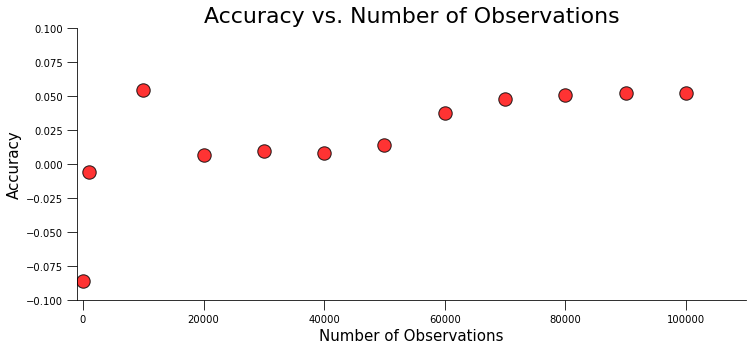

In [102]:
fig = plt.figure(figsize = (12,5))
plt.title("Accuracy vs. Number of Observations", fontsize = 22)

ax = sns.scatterplot(data = score_frame, x = 'size', y = 'accuracy', s = 180, alpha = .8, edgecolor = 'black', color = 'red')

ax.set_xlabel('Number of Observations', fontsize = 15)
ax.set_ylabel('Accuracy', fontsize = 15)
ax.tick_params(size = 10)
ax.set_xlim([-1000,110000])
ax.set_ylim([-.1,.1])
sns.despine()
